<a href="https://colab.research.google.com/github/asymptotebag/covid-sentiment-polarity/blob/master/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Token Sentiment Analysis of COVID-19 Topic Tweets


##Preliminary Model/Baseline Results

In [ ]:
import os
data_root = '/data/'

Mounted at /content/drive


In [ ]:
import numpy as np
import regex as re
"""
Obtained from 6.8610 staff code in the file lab_util.py
"""
class Tokenizer:
  def __init__(self, min_occur=10):
    self.word_to_token = {}
    self.token_to_word = {}
    self.word_count = {}

    self.word_to_token['<unk>'] = 0
    self.token_to_word[0] = '<unk>'
    self.vocab_size = 1

    self.min_occur = min_occur

  def fit(self, corpus):
    for review in corpus:
      review = review.strip().lower()
      words = re.findall(r"[\w']+|[.,!?;]", review)
      for word in words:
          if word not in self.word_count:
              self.word_count[word] = 0
          self.word_count[word] += 1

    for review in corpus:
      review = review.strip().lower()
      words = re.findall(r"[\w']+|[.,!?;]", review)
      for word in words:
        if self.word_count[word] < self.min_occur:
          continue
        if word in self.word_to_token:
          continue
        self.word_to_token[word] = self.vocab_size
        self.token_to_word[self.vocab_size] = word
        self.vocab_size += 1

  def tokenize(self, corpus):
    tokenized_corpus = []
    for review in corpus:
      review = review.strip().lower()
      words = re.findall(r"[\w']+|[.,!?;]", review)
      tokenized_review = []
      for word in words:
        if word not in self.word_to_token:
          tokenized_review.append(0)
        else:
          tokenized_review.append(self.word_to_token[word])
      tokenized_corpus.append(tokenized_review)
    return tokenized_corpus

  def de_tokenize(self, tokenized_corpus):
    corpus = []
    for tokenized_review in tokenized_corpus:
      review = []
      for token in tokenized_review:
        review.append(self.token_to_word[token])
      corpus.append(" ".join(review))
    return corpus
    
class CountVectorizer:
  def __init__(self, min_occur=10):
    self.tokenizer = Tokenizer(min_occur)

  def fit(self, corpus):
    self.tokenizer.fit(corpus)

  def transform(self, corpus):
    n = len(corpus)
    X = np.zeros((n, self.tokenizer.vocab_size))
    for i, review in enumerate(corpus):
      review = review.strip().lower()
      words = re.findall(r"[\w']+|[.,!?;]", review)
      for word in words:
        if word not in self.tokenizer.word_count or self.tokenizer.word_count[word] < self.tokenizer.min_occur:
          X[i][0] += 1
        else:
          X[i][self.tokenizer.word_to_token[word]] += 1
    return X

## Data processing

In [ ]:
import pandas as pd
df_tweets = pd.read_csv(os.path.join(data_root, 'multiclass_dataset_final.csv'))
df_tweets = df_tweets.dropna(subset=['text'])
len(df_tweets)

28364

In [ ]:
# remove neutral tweets
def relable_sentiment(x):
    if x == 2:
        return 1
    else:
        return 0

df_tweets = df_tweets[df_tweets['multiclass_sentiment'] != 1] # remove neutral tweets
df_tweets = df_tweets.drop(['Unnamed: 0.1', 'Unnamed: 0', 'id', 'binary_sentiment'], axis=1)
df_tweets['binary_sentiment'] = df_tweets['multiclass_sentiment'].apply(relable_sentiment)
df_tweets = df_tweets.drop(['multiclass_sentiment', 'norm_sentiment'], axis=1)
df_tweets.head(2)

,text,sentiment,tweet,binary_sentiment
0,so this mean that covid kill they correct,-0.200000,"So this means that covid killed them, correct ...",0
1,I groan at your hand on my body as your hip p...,-0.237037,@SmokingPena *i groan at your hands on my body...,0


In [ ]:
# TRAIN TEST SPLITTING FUNCTIONS

from sklearn.model_selection import train_test_split

def prepare_data(df_data, random_state = 27, test_perc = 0.2, val_perc = 0.1, sentiment_type = 'binary_sentiment'):
    random_state = 27
    test_perc = 0.2

    X = df_data['text'].to_numpy()
    y = df_data[sentiment_type].to_numpy()

    # train test splitting
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_perc, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= val_perc/(1-test_perc), random_state=random_state)
    
    # test correctness
    assert len(X_train) == len(y_train)
    assert len(X_val) == len(y_val)
    assert len(X_test) == len(y_test)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
X_train, X_val, X_test, y_train_binary, y_val_binary, y_test_binary = prepare_data(df_tweets, sentiment_type = 'binary_sentiment')

##TFIDF

In [ ]:
train_reviews = X_train 
test_reviews = X_test
vectorizer = CountVectorizer()
vectorizer.fit(train_reviews)
bow_matrix = vectorizer.transform(train_reviews)
bow_test = vectorizer.transform(test_reviews)

In [ ]:
print(bow_matrix.shape, bow_test.shape)

(12854, 2540) (3673, 2540)


In [ ]:
class TfidfFeaturizer:
    def fit(self, matrix):
        V,D = matrix.shape[0],matrix.shape[1]
        docs_containing = np.clip(matrix,0,1).sum(axis=-1)       #matrix Vx1 of # docs containing a word_i
        self.idf = np.log((D/(docs_containing+1)))
    
    def transform_tfidf(self, matrix):
        V,D = matrix.shape[0], matrix.shape[1]
        self.fit(matrix)
        tile_idf = np.tile(self.idf, (D,1)).T
        output = matrix * tile_idf
        assert not np.isnan(self.idf).any()
        return output
        
td_matrix = bow_matrix.T
featurizer = TfidfFeaturizer()
featurizer.fit(td_matrix)
tfidf_matrix = featurizer.transform_tfidf(td_matrix)
print(f"TF-IDF matrix is {tfidf_matrix.shape[0]} x {tfidf_matrix.shape[1]}")

TF-IDF matrix is 2540 x 12854


In [ ]:
tfidf_test = featurizer.transform_tfidf(bow_test.T).T
tfidf_matrix = tfidf_matrix.T

In [ ]:
from sklearn.linear_model import LogisticRegression

def train_and_eval(train_X, train_y, test_X, test_y):
    # Create and train a model that takes as input a feature 
    # representation of the training data and outputs a sentiment label.
    # Make sure to report the training and test accuracy of your model.

    # print(train_X.shape, "trainX shape", train_y.shape, "train_y shape")
    model = LogisticRegression(max_iter=2000).fit(train_X,train_y)
    return model.score(train_X, train_y), model.score(test_X, test_y),model

print('Logistic regression with tf-idf features')
#modified from hw 
train_labels = y_train_binary
test_labels  = y_test_binary
#end modified from hw 
t_train_score, t_test_score , t_model = train_and_eval(tfidf_matrix, np.array(train_labels), tfidf_test, np.array(test_labels))

Logistic regression with tf-idf features


In [ ]:
print("Training Score: {}".format(t_train_score))
print("Testing  Score: {}".format(t_test_score))

Training Score: 0.9912867589855298
Testing  Score: 0.9044377892730738


In [ ]:
babl = np.vectorize(vectorizer.tokenizer.token_to_word.get)

In [ ]:
def standardize_fancy(coefficients):
    pos_max = max(coefficients)
    mid = 0
    neg_min = min(coefficients)

    new_coeff = []
    for coef in coefficients:
        if coef > 0:
            new_coeff.append((coef - 0)/(pos_max - 0))
        else:
            new_coeff.append((coef - neg_min)/(0 - neg_min)-1)
    
    return np.array(new_coeff)

In [ ]:
tfidf_weight = t_model.coef_.squeeze()
# fancy
tfidf_weight = standardize_fancy(tfidf_weight)

tfidf_weight_top = np.sort(tfidf_weight,)[-5:]
tfidf_ind_top = tfidf_weight.argsort()[-5:][::-1]
tfidf_word_top = babl(tfidf_ind_top)
print("tfidf top indices    ", tfidf_ind_top)
print("tiidf top weights    ", tfidf_weight_top)
print("tfidf top words      ", tfidf_word_top, "\n")

tfidf_weight_bot = np.sort(tfidf_weight,)[:5]
tfidf_ind_bot = tfidf_weight.argsort()[:5][::-1]
tfidf_word_bot = babl(tfidf_ind_bot)
print("tfidf bot indices    ", tfidf_ind_bot)
print("tiidf bot weights    ", tfidf_weight_bot)
print("tfidf bot words      ", tfidf_word_bot, "\n")

tfidf top indices     [1041   24   41   57  536]
tiidf top weights     [0.70247202 0.7172325  0.71890609 0.72759408 1.        ]
tfidf top words       ['nice' 'good' 'many' 'happy' 'most'] 

tfidf bot indices     [ 701 1434  533  547  433]
tiidf bot weights     [-1.         -0.71459869 -0.67050115 -0.60267185 -0.56906718]
tfidf bot words       ['fail' 'insane' 'stupid' 'sick' 'bad'] 



In [ ]:
words_of_interest = ['covid', 'mask', 'quarantine', 'pandemic', 'virus','vaccine','distancing', 'corona', 'trump']
print(tfidf_weight.shape)

(2540,)


In [ ]:
for word in words_of_interest: 
    token_index = vectorizer.tokenizer.word_to_token[word]
    print("Sentiment score: {} , Word: {}".format(np.round(tfidf_weight[token_index], 3),word))

Sentiment score: -0.025 , Word: covid
Sentiment score: -0.008 , Word: mask
Sentiment score: -0.059 , Word: quarantine
Sentiment score: 0.061 , Word: pandemic
Sentiment score: 0.071 , Word: virus
Sentiment score: 0.014 , Word: vaccine
Sentiment score: 0.123 , Word: distancing
Sentiment score: 0.036 , Word: corona
Sentiment score: -0.005 , Word: trump


##BOW

In [ ]:
bow_train_score, bow_test_score, bow_model = train_and_eval(bow_matrix, np.array(train_labels),bow_test, test_labels)
print('bow training score:{}'.format(bow_train_score))
print('bow testing score:{}'.format(bow_test_score))

bow training score:0.9699704372179866
bow testing score:0.9215899809420093


In [ ]:
bow_weight = bow_model.coef_.squeeze()

bow_weight = standardize_fancy(bow_weight)

bow_weight_top = np.sort(bow_weight)[-5:]
bow_ind_top = bow_weight.argsort()[-5:][::-1]
bow_word_top = babl(bow_ind_top)

print("BOW top indices      ", bow_ind_top)
print("BOW top weights      ", bow_weight_top)
print("BOW top words        ", bow_word_top, "\n")

bow_weight_bot = np.sort(bow_weight)[:5]
bow_ind_bot = bow_weight.argsort()[:5][::-1]
bow_word_bot = babl(bow_ind_bot)

print("BOW bot indices      ", bow_ind_bot)
print("BOW bot weights      ", bow_weight_bot)
print("BOW bot words        ", bow_word_bot, "\n")

BOW top indices       [750  24 536  57 471]
BOW top weights       [0.84239532 0.84382688 0.85874464 0.92340251 1.        ]
BOW top words         ['lol' 'good' 'most' 'happy' 'own'] 

BOW bot indices       [339 874 533 547 433]
BOW bot weights       [-1.         -0.79519945 -0.72860134 -0.702407   -0.69883462]
BOW bot words         ['sorry' 'dangerous' 'stupid' 'sick' 'bad'] 



In [ ]:
for word in words_of_interest: 
    token_index = vectorizer.tokenizer.word_to_token[word]
    print("Sentiment score: {} , Word: {}".format(np.round(bow_weight[token_index], 3),word))

Sentiment score: -0.018 , Word: covid
Sentiment score: 0.003 , Word: mask
Sentiment score: -0.062 , Word: quarantine
Sentiment score: 0.028 , Word: pandemic
Sentiment score: -0.009 , Word: virus
Sentiment score: 0.028 , Word: vaccine
Sentiment score: 0.058 , Word: distancing
Sentiment score: 0.013 , Word: corona
Sentiment score: -0.021 , Word: trump


In [ ]:
abc = [idx for idx, sent in enumerate(X_train) if 'less' in sent]
X_train[abc][:5]

array(['there be systematic fake news by liberal amp opposition vulture on covid situation govt need to dispel this through print medium give the rate at which people be come out of hospital amp the less fatality',
       'a year today in a heart of a global pandemic when the whole world be on a lockdown the great ghanaian album be bear and the rest be a history no album coulda ever perform well than this album unless stonebwoy himself bring another album ',
       'when it be time to plan amp act they be busy with rally amp export vaccine oxygen amp vaccine then allow event like kumbh now try to shift the blame on people never in human history we ever see a more shameless amp irresponsible govt ',
       'mr a kejriwal when you be careless about corona guideline to follow in delhi now shout for oxygen vaccine have visit in to in march 21 in delhi ludhiana no one wear mask ',
       'fatherless idiot '], dtype=object)

In [ ]:
bow_matrix.shape

(12854, 2540)

### PYTORCH POWER

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torch_data

class ContinuousClassifier(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.linear = nn.Linear(vocab_size, 1)

    def forward(self, x):
        x = self.linear(x)
        m = nn.Sigmoid()
        out = m(x)
        return out
        

In [ ]:
from tqdm import tqdm

def training(loader, vocab_size, n_epochs):
    device = torch.device('cuda')  # run on colab gpu
    model = ContinuousClassifier(vocab_size).to(device)
    opt = optim.Adam(model.parameters(), lr=0.0001)
    #opt = optim.SGD(model.parameters(), lr=0.00001, momentum=0.9)

    loss_fn = nn.MSELoss(reduction='mean')

    losses = []  
    for epoch in tqdm(range(n_epochs)):
        epoch_loss = 0
        for context, label in loader:
            preds = model(context.float().to(device))
            
            model.zero_grad()
            loss = loss_fn(preds.float(), label.float().to(device))
            loss.backward()
            opt.step()
            epoch_loss += loss.item()
        losses.append(epoch_loss)

    embedding_matrix = model.linear.weight.data.cpu().numpy()  # Your code here!

    return embedding_matrix, model, losses

In [ ]:
batch_size = 16
loader = torch_data.DataLoader([(bow_matrix[i], y_train_norm[i]) for i in range(len(X_train))], batch_size=batch_size, shuffle=True)

nn_weights, model, losses = training(loader, bow_matrix.shape[1], 30)

  0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 30/30 [00:29<00:00,  1.02it/s]


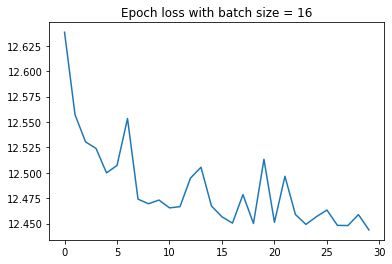

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.title('Epoch loss with batch size = 16')
plt.show()

In [ ]:
bow_weight = nn_weights.T.flatten()
bow_weight = fancy_sentimentizer(bow_weight)

bow_weight_top = np.sort(bow_weight)[-5:]
bow_ind_top = bow_weight.argsort()[-5:][::-1]
bow_word_top = babl(bow_ind_top)

print("BOW top indices      ", bow_ind_top)
print("BOW top weights      ", bow_weight_top)
print("BOW top words        ", bow_word_top, "\n")


bow_weight_bot = np.sort(bow_weight)[:5]
bow_ind_bot = bow_weight.argsort()[:5][::-1]
bow_word_bot = babl(bow_ind_bot)

print("BOW bot indices      ", bow_ind_bot)
print("BOW bot weights      ", bow_weight_bot)
print("BOW bot words        ", bow_word_bot, "\n")

BOW top indices       [1812 1192  277   69  670]
BOW top weights       [0.6608989  0.6666434  0.787606   0.88584256 1.        ]
BOW top words         ['proud' 'lmao' 'lol' 'beautiful' 'happy'] 

BOW bot indices       [1162   82 1274 1058  296]
BOW bot weights       [-1.         -0.8026257  -0.8020967  -0.73575294 -0.7267262 ]
BOW bot words         ['horrible' 'mad' 'evil' 'crazy' 'outrageous'] 



In [ ]:
for word in words_of_interest: 
    token_index = vectorizer.tokenizer.word_to_token[word]
    print("Sentiment score: {} , Word: {}".format(np.round(bow_weight[token_index], 5),word))

Sentiment score: 0.07009000331163406 , Word: covid
Sentiment score: 0.005779999773949385 , Word: mask
Sentiment score: 0.28547999262809753 , Word: quarantine
Sentiment score: 0.04077000170946121 , Word: pandemic
Sentiment score: -0.05706999823451042 , Word: virus
Sentiment score: 0.12188000231981277 , Word: vaccine
Sentiment score: 0.132750004529953 , Word: distancing
Sentiment score: 0.02589000016450882 , Word: corona
Sentiment score: -0.025110000744462013 , Word: trump


In [ ]:
#### TF IDF

In [ ]:
batch_size = 16
loader = torch_data.DataLoader([(tfidf_matrix[i], y_train_norm[i]) for i in range(len(X_train))], batch_size=batch_size, shuffle=True)

nn_weights_tf, model, losses = training(loader, tfidf_matrix.shape[1], 40)

100%|██████████| 40/40 [00:35<00:00,  1.13it/s]


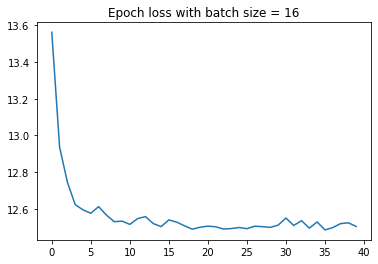

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.title('Epoch loss with batch size = 16')
plt.show()

In [ ]:
bow_weight = nn_weights_tf.T.flatten()
bow_weight = fancy_sentimentizer(bow_weight)

bow_weight_top = np.sort(bow_weight)[-5:]
bow_ind_top = bow_weight.argsort()[-5:][::-1]
bow_word_top = babl(bow_ind_top)

print("BOW top indices      ", bow_ind_top)
print("BOW top weights      ", bow_weight_top)
print("BOW top words        ", bow_word_top, "\n")


bow_weight_bot = np.sort(bow_weight)[:5]
bow_ind_bot = bow_weight.argsort()[:5][::-1]
bow_word_bot = babl(bow_ind_bot)

print("BOW bot indices      ", bow_ind_bot)
print("BOW bot weights      ", bow_weight_bot)
print("BOW bot words        ", bow_word_bot, "\n")

BOW top indices       [ 489 1194  752 1907 1590]
BOW top weights       [0.86279    0.89482534 0.92735386 0.97195685 1.        ]
BOW top words         ['jared' 'permission' 'wealth' 'reassurance' 'timely'] 

BOW bot indices       [ 693 2104 1896  390  391]
BOW bot weights       [-1.         -0.87785435 -0.79389596 -0.59770834 -0.5304843 ]
BOW bot words         ['holten' 'bloodmatter' 'premature' 'steward' 'ada'] 



In [ ]:
for word in words_of_interest: 
    token_index = vectorizer.tokenizer.word_to_token[word]
    print("Sentiment score: {} , Word: {}".format(np.round(bow_weight[token_index], 5),word))

Sentiment score: 0.6454499959945679 , Word: covid
Sentiment score: 0.1534000039100647 , Word: mask
Sentiment score: 0.47828999161720276 , Word: quarantine
Sentiment score: 0.28431999683380127 , Word: pandemic
Sentiment score: 0.10083000361919403 , Word: virus
Sentiment score: 0.32256001234054565 , Word: vaccine
Sentiment score: 0.08641999959945679 , Word: distancing
Sentiment score: 0.2902800142765045 , Word: corona
Sentiment score: 0.3302299976348877 , Word: trump
